# 1. Import and Install Dependencies

# Run installs

In [4]:
!pip install mediapipe


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip
'clear' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install opencv-python
!pip install mediapipe
!pip installmatplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\serwu\AppData\Local\Temp\pip-install-cvg03obp\tensorflow-gpu_df0e8dc0c645489e88f0d85927830c91\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build wheels for tensorflow-gpu, which is required to install pyproject.toml-

ERROR: unknown command "installmatplotlib"



# Run preps1R

In [8]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

def rename_dirs(starting_pos):
    current_dir = os.path.join(os.getcwd(), 'data_to_modify')
    
    directories = [name for name in os.listdir(current_dir) if os.path.isdir(os.path.join(current_dir, name))]
    
    if len(directories) == 0:
        return
    
    # Get the current directory
    current_dir = os.path.join(current_dir, directories[0])
    
    # List all directories in the current location
    directories = [name for name in os.listdir(current_dir) if os.path.isdir(os.path.join(current_dir, name))]

    
    if starting_pos > 0:
        directories.sort(reverse=True, key=int)
    else:
        directories.sort(reverse=False, key=int)

    # Print the directories
    for directory in directories:
        new_name = int(directory) + int(starting_pos)
        os.rename(os.path.join(current_dir, str(directory)), os.path.join(current_dir, str(new_name)))

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
# actions = np.array(['pc_on', 'pc_off', 'pc_lock', 'move_left', 'move_right', 'show_destkop', 'mute', 'unmute'])
actions = np.array(['pc_on', 'pc_off', 'move_left', 'move_right'])

# Thirty videos worth of data
no_sequences = 300

# Videos are going to be 30 frames in length
sequence_length = 30

# Run test keypoints

In [163]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

# Setup Folders for Collection

In [388]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Rename dirs

In [395]:
rename_dirs(0)

# Collect Keypoint Data for Training

In [2]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [3]:
cap.release()
cv2.destroyAllWindows()

# Preprocess Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
y = to_categorical(labels).astype(int)
X = np.array(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [ ]:
label_map

In [ ]:
np.array(sequences).shape

In [ ]:
np.array(labels).shape

In [ ]:
y_test.shape

In [ ]:
X.shape

# Build and Train LSTM Neural Network

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
res = [.7, 0.2, 0.1]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
36/36 [==============================] - 1s 33ms/step - loss: 0.3871 - categorical_accuracy: 0.8579
Epoch 2/2000
36/36 [==============================] - 1s 34ms/step - loss: 0.1946 - categorical_accuracy: 0.9342
Epoch 3/2000
36/36 [==============================] - 1s 33ms/step - loss: 0.1255 - categorical_accuracy: 0.9544
Epoch 4/2000
36/36 [==============================] - 1s 33ms/step - loss: 0.0934 - categorical_accuracy: 0.9711
Epoch 5/2000
36/36 [==============================] - 1s 33ms/step - loss: 0.0899 - categorical_accuracy: 0.9746
Epoch 6/2000
36/36 [==============================] - 1s 32ms/step - loss: 0.1397 - categorical_accuracy: 0.9544
Epoch 7/2000
36/36 [==============================] - 1s 32ms/step - loss: 0.0688 - categorical_accuracy: 0.9746
Epoch 8/2000
36/36 [==============================] - 1s 32ms/step - loss: 0.0523 - categorical_accuracy: 0.9868
Epoch 9/2000
36/36 [==============================] - 1s 33ms/step - loss: 0.0646 - categorical_

# 8. Make Predictions

In [260]:
res = model.predict(X_test)

1/1 [==============================] - 1s 529ms/step


In [261]:
actions[np.argmax(res[4])]

'move_left'

In [262]:
actions[np.argmax(y_test[4])]

'move_right'

# 9. Save Weights

In [263]:
model.save('action.h5')

E:\Code\Studia\EngineeringThesis\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
model.save('my_model.keras')

model.load('my_model.keras')

In [374]:
del model

NameError: name 'model' is not defined

In [6]:
model.load_weights('action.h5')

NameError: name 'model' is not defined

In [18]:
from tensorflow import keras
model = keras.models.load_model('150rc4fun.keras')

# 10. Evaluation using Confusion Matrix and Accuracy

In [12]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [10]:
yhat = model.predict(X_test)

2/2 [==============================] - 0s 19ms/step


In [11]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [12]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[40,  0],
        [18,  2]],

       [[44,  0],
        [16,  0]],

       [[ 2, 50],
        [ 0,  8]],

       [[44,  0],
        [16,  0]]], dtype=int64)

In [13]:
accuracy_score(ytrue, yhat)

0.16666666666666666

# 11. Test in Real Time

In [15]:
colors = [(245,117,16), (117,245,16), (16,117,245), (1,100,200)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

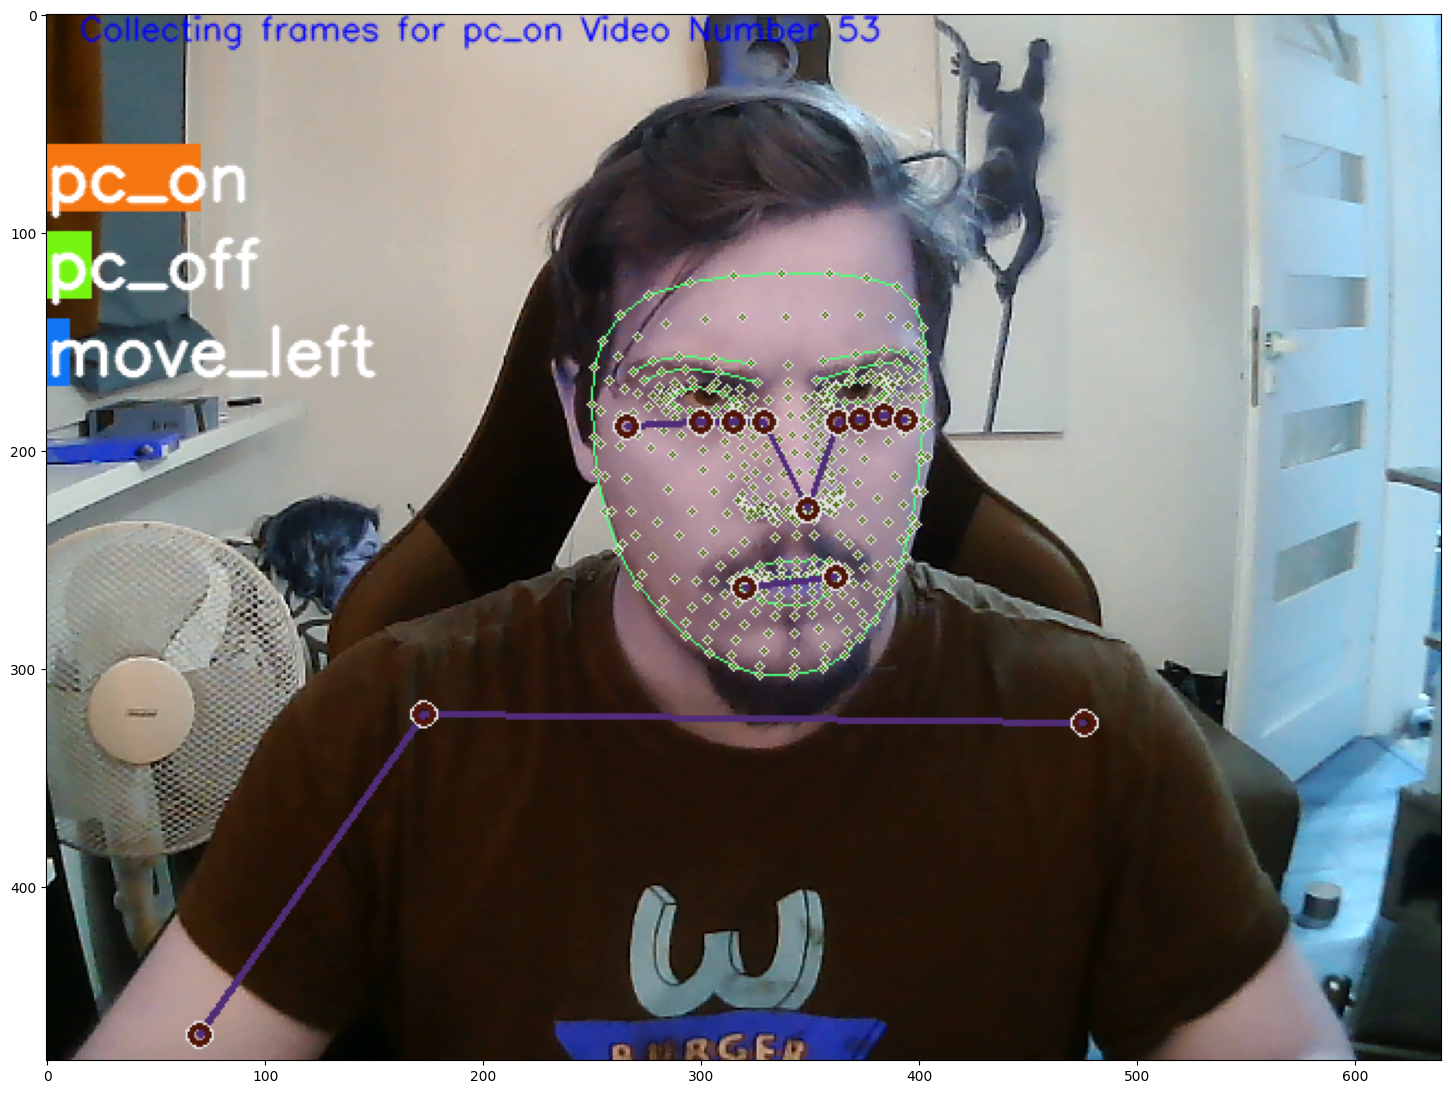

In [15]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [16]:
sequence.reverse()

AttributeError: 'int' object has no attribute 'reverse'

In [ ]:
len(sequence)

In [17]:
sequence.append('def')

AttributeError: 'int' object has no attribute 'append'

In [18]:
sequence.reverse()

AttributeError: 'int' object has no attribute 'reverse'

In [19]:
sequence[-30:]

TypeError: 'int' object is not subscriptable

In [19]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.1) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            print(res)
            print(colors)
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [14]:
cap.release()
cv2.destroyAllWindows()

In [247]:
res[np.argmax(res)] > threshold

True

In [ ]:
(num_sequences,30,1662)

In [240]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[5.532469e-04, 9.974770e-01, 1.969744e-03]], dtype=float32)